In [25]:
from jax import numpy as np
from numpy import random

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from scipy.special import erfc
def H(x):
    return erfc(x/np.sqrt(2))/2

$$ SNR = \frac{\|\Delta x_0\|^2 + (R_b^2 R_a^{-2} - 1)/m}{\sqrt{D^{-1}/m + \|\Delta x_0 \cdot U_a\|^2 + \|\Delta x_0 \cdot U_b\|^2 / m}} $$

In [4]:
def SNR(signal, bias, D, overlap, m):
    return 1/2*(signal + bias/m) / np.sqrt(1/D/m + overlap + 1/D * m*(m-1)/m**4)

In [5]:
N = 500
D = 50
P = 5000

def few_shot_err(N,D,P,m,Ra,Rb,theta=np.pi/2):
    # Subspaces
    U = random.randn(N,2*(D+1))
    U,_ = np.linalg.qr(U)
    Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=-1)
    
    # Center-subspace overlaps
    x0a = np.sin(theta)*x0a + np.cos(theta)*Ua.sum(-1,keepdims=True) / np.sqrt(D)
    x0a /= np.sqrt(2)
    x0b = np.sin(theta)*x0b + np.cos(theta)*Ub.sum(-1,keepdims=True) / np.sqrt(D)
    x0b /= np.sqrt(2)

    # Training examples
    sa = random.randn(D,P,m)
    sa /= np.linalg.norm(sa,axis=0)
    sb = random.randn(D,P,m)
    sb /= np.linalg.norm(sb,axis=0)
    Xatrain = x0a + Ra*Ua@sa.mean(-1)
    Xbtrain = x0b + Rb*Ub@sb.mean(-1)
    Xtrain = np.stack([Xatrain,Xbtrain])

    # Testing examples
    ssa = random.randn(D,P)
    ssa /= np.linalg.norm(ssa,axis=0)
    ssb = random.randn(D,P)
    ssb /= np.linalg.norm(ssb,axis=0)
    Xatest = x0a + Ra*Ua@ssa
    Xbtest = x0b + Rb*Ub@ssb

    # Evaluate
    da = ((Xatest - Xtrain)**2).sum(1)
#     db = ((Xbtest - Xtrain)**2).sum(1)
    erra = (da.argmin(0)!=0).mean()
#     errb = (db.argmin(0)!=1).mean()
#     err = (erra+errb)/2
    
    return erra

In [6]:
ms = [1,3,5]
Rs = 1/np.linspace(0.4,1,20)
errs = []
for m in ms:
    for R in tqdm(Rs):
        Ra = Rb = R
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_signal = np.stack(errs).reshape(len(ms),len(Rs))

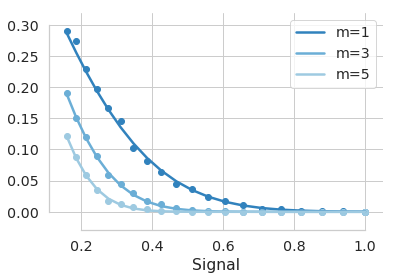

In [7]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_signal,ms):
        plt.scatter((1/Rs)**2,err)
        bias = 0
        overlap = 0
        signals = (1/Rs)**2
        plt.plot(signals, H(SNR(signals, bias, D, overlap, m)), label='m='+str(m))
#         plt.yscale('log')
plt.xlabel('Signal')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_signal.pdf')

In [8]:
ms = [1,3,5]
R = 2
Ra = Rb = R
Ds = np.linspace(10,200,20,dtype='int')
errs = []
for m in ms:
    for D in tqdm(Ds):
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_dim = np.stack(errs).reshape(len(ms),len(Ds))

/home/bsorsch/.tf2/lib/python3.5/site-packages/jax/lax/lax.py:4505: UserWarning: Explicitly requested dtype int requested in linspace is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


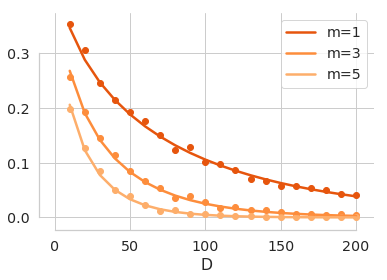

In [9]:
with sns.color_palette('tab20c'):
    for i in range(4):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_dim,ms):
        plt.scatter(Ds,err)
        bias = 0
        overlap = 0
        signal = 1/R**2
        plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('D')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_dimension.pdf')

In [10]:
# Bias
ms = [1,3,5]
R = 2
D = 50
Ra = R
biases = np.linspace(-1,1,20)
Rbs = np.sqrt(biases+1)*Ra

errs = []
for m in ms:
    for Rb in tqdm(Rbs):
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs_bias = np.stack(errs).reshape(len(ms),len(Rs))

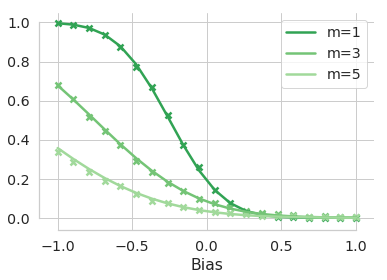

In [11]:
with sns.color_palette('tab20c',):
    for i in range(8):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs_bias,ms):
        plt.scatter(biases,err,marker='x')
        overlap = 0
        signal = 1/R**2
        plt.plot(biases, H(SNR(signal, biases, D, overlap, m)), label='m='+str(m))
# plt.yscale('log')
plt.xlabel('Bias')
plt.legend()
sns.despine(trim=True);
# plt.savefig('images/geometry_components_bias.pdf')

In [12]:
thetas = np.linspace(np.pi/2,np.pi,20)
R = 2
Ra = Rb = R
errs = []
for m in ms:
    for theta in tqdm(thetas):
        err = few_shot_err(N,D,P,m,Ra,Rb,theta)
        errs.append(err)
errs_overlap = np.stack(errs).reshape(len(ms),len(Rs))

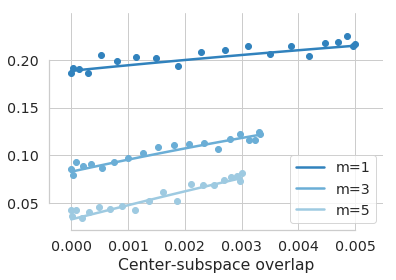

In [13]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_overlap,ms):
        overlaps = np.cos(thetas)**2/(2*D*R**2)*(1+1/m)
        plt.scatter(overlaps,err)
        bias = 0
        signal = 1/R**2
        plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, m)), label='m='+str(m))
#         plt.yscale('log')
plt.xlabel('Center-subspace overlap')
plt.legend()
plt.xlim([-0.0004,0.0055])
sns.despine(trim=True);
# plt.savefig('images/geometry_components_center_subspace.pdf')

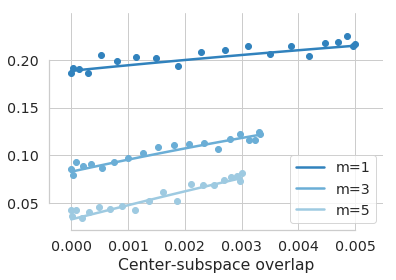

In [14]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs_overlap,ms):
        overlaps = np.cos(thetas)**2/(2*D*R**2)*(1+1/m)
        plt.scatter(overlaps,err)
        bias = 0
        signal = 1/R**2
        plt.plot(overlaps, H(SNR(signal, bias, D, overlaps, m)), label='m='+str(m))
#         plt.yscale('log')
plt.xlabel('Center-subspace overlap')
plt.legend()
plt.xlim([-0.0004,0.0055])
sns.despine(trim=True);
# plt.savefig('images/geometry_components_center_subspace.pdf')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

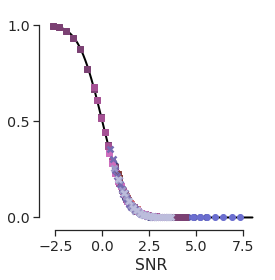

In [38]:
cmap = plt.cm.get_cmap('tab20c')
cmapb = plt.cm.get_cmap('tab20b')

plt.figure(figsize=(4,4))
x = np.linspace(-2.5,8,100)
plt.plot(x,H(x), c='black',zorder=-99, linewidth=2)

m = 1
bias = 0
overlap = 0
signals = (1/Rs)**2
for i,m in enumerate(ms):
    plt.scatter(SNR(signals, bias, D, overlap, m), errs_signal[i], c=cmapb(i))

# Dimension
signal = 1/R**2
for i,m in enumerate(ms):
    plt.scatter(SNR(signal, bias, Ds, overlap, m), errs_dim[i], marker='x', c=cmap(i+12), zorder=99)

# Bias
for i,m in enumerate(ms):
    plt.scatter(SNR(signal, biases, D, overlap, m), errs_bias[i], marker='s', c=cmapb(i+16))

overlaps = np.cos(thetas)**2/(2*D*R**2)*(1+1/m)
for i,m in enumerate(ms):
    plt.scatter(SNR(signal, bias, D, overlaps, m), errs_overlap[i], marker='v', c=cmapb(i+12))

plt.yticks([0,0.5,1])
sns.despine(trim=True)
plt.xlabel('SNR');

plt.savefig('images/geometry_components_SNR.pdf')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

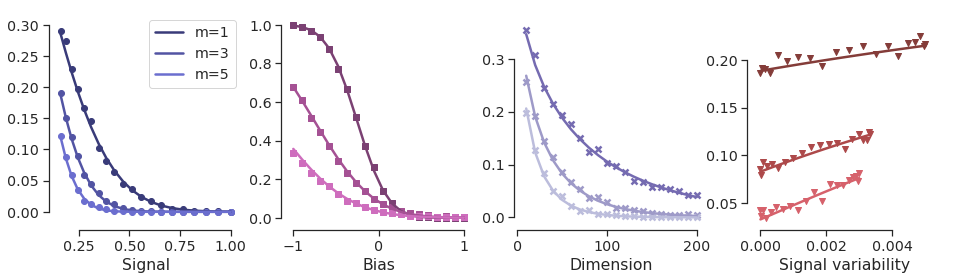

In [36]:
cmap = plt.cm.get_cmap('tab20c')
cmapb = plt.cm.get_cmap('tab20b')

plt.figure(figsize=(16,4))
plt.subplot(141)
m = 1
bias = 0
overlap = 0
signals = (1/Rs)**2
for i,m in enumerate(ms):
    plt.scatter(signals, errs_signal[i], c=cmapb(i))
    plt.plot(signals, H(SNR(signals, bias, D, overlap, m)), label='m='+str(m), c=cmapb(i))
plt.legend()
plt.xlabel('Signal')

plt.subplot(143)
# Dimension
signal = 1/R**2
for i,m in enumerate(ms):
    plt.scatter(Ds, errs_dim[i], marker='x', c=cmap(i+12))
    plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)), c=cmap(i+12))
plt.xlabel('Dimension')

plt.subplot(142)
# Bias
for i,m in enumerate(ms):
    plt.scatter(biases,errs_bias[i], marker='s', c=cmapb(i+16))
    plt.plot(biases, H(SNR(signal, biases, D, overlap, m)), c=cmapb(i+16))
plt.xlabel('Bias')

plt.subplot(144)

for i,m in enumerate(ms):
    overlaps = np.cos(thetas)**2/(2*D*R**2)*(1+1/m)
    plt.scatter(overlaps,errs_overlap[i], marker='v', c=cmapb(i+12))
    plt.plot(overlaps,H(SNR(signal, bias, D, overlaps, m)), c=cmapb(i+12))
    plt.xlim([-0.0004,0.0055])
    plt.xlabel('Signal variability')

sns.despine(trim=True)
plt.savefig('images/geometry_components.pdf')